# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

**Integrantes**
- Nicolás Robayo Pardo
- Andrés Cepeda

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **18 de octubre** y se realizará a través de Bloque Neón.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [3]:

data = pd.read_csv( "creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv( "creditCardScore/credit_record.csv", encoding = 'utf-8')

In [4]:
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [ ]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Preparación de los Datos

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [ ]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data
new_data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [ ]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [ ]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [ ]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [ ]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [ ]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [ ]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [ ]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [ ]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [ ]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

In [ ]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Posesión de un Automóvil

In [ ]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Posesión de un Inmueble

In [ ]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Posesión de un Teléfono

In [ ]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Posesión de Correo Electrónico (Email)

In [ ]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Posesión de Teléfono para Trabajo

In [ ]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Descriptores Continuos

#### Cantidad de Hijos

In [ ]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [ ]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [ ]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0,0,0


#### Ingresos Anuales

Gráfica de Histograma para observar la distribución.

In [ ]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


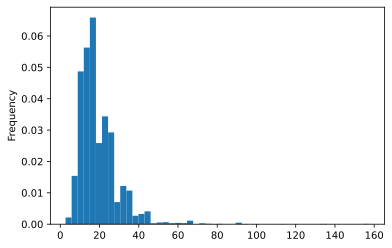

In [ ]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [ ]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

El IV de esta variable es: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


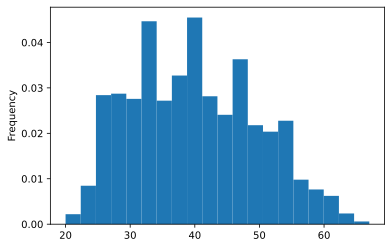

In [ ]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [ ]:
new_data = convert_dummy(new_data,'gp_Age')

#### Años de Trabajo

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

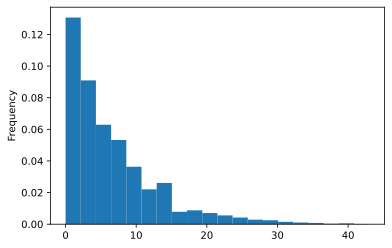

In [ ]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [ ]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [ ]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Student                    10
State servant            2437
Working                 15622
Commercial associate     7052
Pensioner                  13
Name: inctp, dtype: int64
Student                 0.000398
State servant           0.096960
Working                 0.621549
Commercial associate    0.280576
Pensioner               0.000517
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [ ]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [ ]:
new_data = convert_dummy(new_data,'occyp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [ ]:
new_data = convert_dummy(new_data,'houtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [ ]:
new_data = convert_dummy(new_data,'edutp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Married                 0.696626
Civil marriage          0.084865
Widow                   0.023076
Single / not married    0.137065
Separated               0.058367
Name: famtp, dtype: float64

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [ ]:
new_data = convert_dummy(new_data,'famtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [ ]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Separación de datos en conjuntos: entrenamiento y prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```


### A. Top 6

In [ ]:
X_train

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
32515,1.0,0.0,1.0,0.0,0.0,0.41373,0.0,0.0,0.0,0.0,0.58627,0.0,0.0,0.0,0.0,0.41373,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14471,0.0,0.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16400,0.0,0.0,0.0,0.0,0.0,1.00000,1.0,0.0,0.0,1.0,0.00000,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29956,1.0,0.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39904,0.0,1.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,1.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38963,0.0,1.0,1.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.0,0.0,0.00000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19666,0.0,0.0,0.0,0.0,1.0,0.00000,1.0,0.0,0.0,1.0,0.00000,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3278,0.0,1.0,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.00000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22944,1.0,1.0,1.0,0.0,0.0,1.00000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
categories = ['gp_Age_high', 'gp_Age_highest', 'gp_Age_low','gp_Age_lowest',
                        'famtp_Civil marriage','famtp_Separated','famtp_Single / not married','famtp_Widow', 
                         'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
                         'Reality', 'Gender', 
                         'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']

X_train_subA = X_train[ categories]

X_test_subA = X_test[categories]

X_train_subA.head()

,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,Reality,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
32515,0.0,0.0,0.0,0.58627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14471,0.0,0.0,1.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16400,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29956,0.0,0.0,0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39904,0.0,0.0,1.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### B. Últimos 6

In [ ]:
categories = ['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment', 'houtp_Rented apartment', 'houtp_With parents',
              'famsizegp_1', 'famsizegp_3more',
              'occyp_hightecwk', 'occyp_officewk',
              'gp_inc_medium',  'gp_inc_high',
              'wkphone', 
              'ChldNo_1', 'ChldNo_2More']
X_train_subB = X_train[categories]

X_test_subB = X_test[categories]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.41373,0.0,0.0,0.41373,0.0,1.0,0.0
14471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,1.00000,0.0,0.0,0.0
16400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.00000,1.0,0.0,0.0
29956,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.0,0.0,1.00000,0.0,0.0,0.0
39904,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00000,0.0,0.0,1.00000,0.0,0.0,0.0


## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

In [ ]:
X_train_subC = X_train
X_test_subC = X_test

# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

### Caso A

Precisión 0.5903
      0     1
0  3879  3535
1  2540  4874
[[3879 3535]
 [2540 4874]]
La sensibilidad es de  0.657404909630429


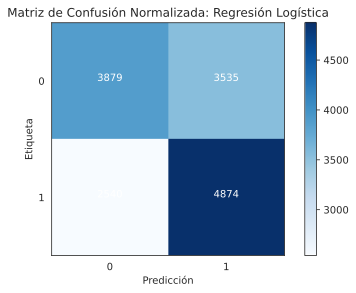

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(  X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')
print("La sensibilidad es de ",confusion_matrix(y_test,y_predict)[1,1]/(confusion_matrix(y_test,y_predict)[1,1]+confusion_matrix(y_test,y_predict)[1,0]))

## Caso B

Precisión 0.54323
      0     1
0  3947  3467
1  3306  4108
[[3947 3467]
 [3306 4108]]
La sensibilidad es de  0.554086862692204


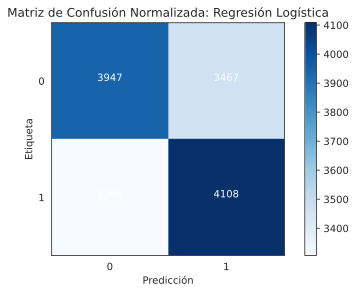

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB, y_train  ) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict( X_test_subB ) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')
print("La sensibilidad es de ",confusion_matrix(y_test,y_predict)[1,1]/(confusion_matrix(y_test,y_predict)[1,1]+confusion_matrix(y_test,y_predict)[1,0]))

## Caso C

Precisión 0.60197
      0     1
0  3965  3449
1  2453  4961
[[3965 3449]
 [2453 4961]]
La sensibilidad es de  0.6691394658753709


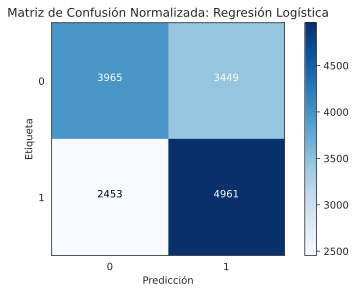

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subC, y_train   ) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict( X_test_subC ) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')
print("La sensibilidad es de ",confusion_matrix(y_test,y_predict)[1,1]/(confusion_matrix(y_test,y_predict)[1,1]+confusion_matrix(y_test,y_predict)[1,0]))

### Análisis
La regresión logística es un buen clasificador binario con rendimiento aceptable. El mejor modelo es aquel con todas las variables el cual logra una precisión de 60% seguido por el modelo con la mitad superior de las variables con el mejor puntaje IV (que tienen la mejor capacidad de predicción) con una precisión del 59.43%. Finalmente, es de esperarse que el modelo con la mitad inferior de las peores variables con puntaje IV sea el que menos precisión tenga con 53,3%. 

En términos de la clase desbalanceada, el modelo con la mejor sensibilidad es aquel con todas las variables (C) con una sensibilidad del 66.15%, luego está el A con 64.97% y por último el B con 55.55%. Esta métrica es clave dado que el proposito del modelo es detectar si el cliente tendrá un mal crédito. En este sentido escogemos el modelo con todas las variables dado que logra la mejor distinción entre aquellos usuarios que son malos deudores.

## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.

### Caso A

Precisión 0.82627
      0     1
0  6226  1188
1  1388  6026
[[6226 1188]
 [1388 6026]]


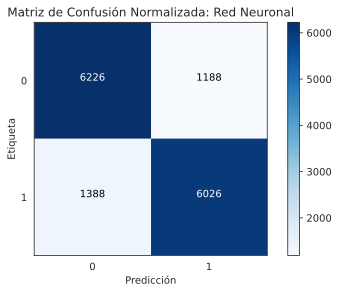

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam'
                      ) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( X_train_subA, y_train ) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict( X_test_subA ) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Precisión 0.76632
      0     1
0  5597  1817
1  1648  5766
[[5597 1817]
 [1648 5766]]


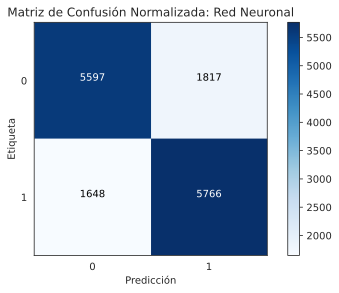

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier( hidden_layer_sizes=(20,20),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam'  ) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( X_train_subB, y_train  ) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict( X_test_subB ) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Precisión 0.95286
      0     1
0  6992   422
1   277  7137
[[6992  422]
 [ 277 7137]]


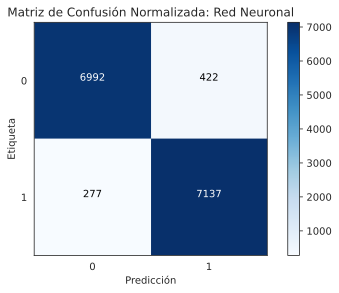

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam'   ) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( X_train_subC, y_train  ) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict( X_test_subC ) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Conclusiones Parte 2

El perceptrón multicapa tiene un mucho mejor rendimiento que la regresión logística en todos los casos. Esto sucede probablemente porque la frontera de decisión subyacente es no lineal y la red neuronal logra explotar este hecho para reducir el sesgo del modelo considerablemente. El mejor resultado se obtiene con el grupo C de variables, es decir, con todas las variables. Con una precisión de 95.3% en el conjunto de validación, la cual es muy superior al mejor modelo de regresión logística. 

Otra gran ventaja del peceptron es que logra una alta presición pero manteniendo altos niveles de sensibilidad y especificidad. Este ejemplo demuestra como con un gran número de datos y un modelo altamente no lineal se pueden obtener excelentes resultados de clasificación.

Por otra parte, también se evidencia la capacidad de predicción del perceptrón multicapa teniendo en cuenta que la implementación no fue complicada ni fue necesaria una arquitectura altamenta compleja o profunda para encontrar la frontera de clasificación. Con solamente 2 capas y 20 neuronas en cada una la red neuronal logra excelentes resultados, por lo cual para conjuntos de datos más complejos de clasificar se evidencia el potencial que tiene.

# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.

### Caso A

In [ ]:
# Separación de datos en dos mitades (como dicen en la instrucción).
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.5,
                                                    random_state = 10086)

In [ ]:
grid_values = [5, 10, 20, 50, 100]
accuracy_CA = np.zeros(len(grid_values))

from sklearn.neural_network import MLPClassifier

for i, hlsc1 in enumerate(grid_values):
  model = MLPClassifier(hidden_layer_sizes=(hlsc1),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam') 
  model.fit( X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
  y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #
  accuracy_CA[i] = accuracy_score(y_test, y_predict) 
  print(f'Para 1 capa escondida con {hlsc1} neuronas: Precisión {round(accuracy_CA[i],5)}') # Muestra el resultado


Para 1 capa escondida con 5 neuronas: Precisión 0.7254
Para 1 capa escondida con 10 neuronas: Precisión 0.78274
Para 1 capa escondida con 20 neuronas: Precisión 0.90822
Para 1 capa escondida con 50 neuronas: Precisión 0.94727
Para 1 capa escondida con 100 neuronas: Precisión 0.96192


### Caso B

In [ ]:
accuracy_CB = np.zeros(len(grid_values))

from sklearn.neural_network import MLPClassifier

for i, hlsc1 in enumerate(grid_values):
  model = MLPClassifier(hidden_layer_sizes=(hlsc1,hlsc1),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam') 
  model.fit( X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
  y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #
  accuracy_CB[i] = accuracy_score(y_test, y_predict) 
  print(f'Para 2 capas escondidas con {(hlsc1, hlsc1)} neuronas: Precisión {round(accuracy_CB[i],5)}') # Muestra el resultado

Para 2 capas escondidas con (5, 5) neuronas: Precisión 0.76307
Para 2 capas escondidas con (10, 10) neuronas: Precisión 0.86189
Para 2 capas escondidas con (20, 20) neuronas: Precisión 0.93185
Para 2 capas escondidas con (50, 50) neuronas: Precisión 0.95707
Para 2 capas escondidas con (100, 100) neuronas: Precisión 0.95707


### Caso C

In [ ]:
accuracy_CC = np.zeros(len(grid_values))

from sklearn.neural_network import MLPClassifier

for i, hlsc1 in enumerate(grid_values):
  model = MLPClassifier(hidden_layer_sizes=(hlsc1,hlsc1,hlsc1),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'adam') 
  model.fit( X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
  y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #
  accuracy_CC[i] = accuracy_score(y_test, y_predict) 
  print(f'Para 3 capas escondidas con {(hlsc1, hlsc1, hlsc1)} neuronas: Precisión {round(accuracy_CC[i],5)}') # Muestra el resultado

Para 3 capas escondidas con (5, 5, 5) neuronas: Precisión 0.77622
Para 3 capas escondidas con (10, 10, 10) neuronas: Precisión 0.87031
Para 3 capas escondidas con (20, 20, 20) neuronas: Precisión 0.95253
Para 3 capas escondidas con (50, 50, 50) neuronas: Precisión 0.95885
Para 3 capas escondidas con (100, 100, 100) neuronas: Precisión 0.95735


### Gráficas Evaluativas

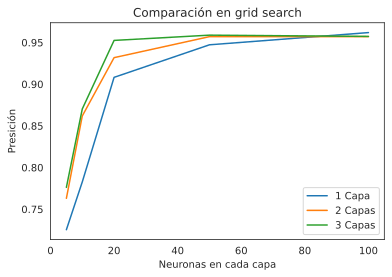

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(grid_values, accuracy_CA)
plt.plot(grid_values, accuracy_CB)
plt.plot(grid_values, accuracy_CC)
plt.xlabel("Neuronas en cada capa")
plt.ylabel("Presición")
plt.legend(labels=["1 Capa", "2 Capas", "3 Capas"],loc="bottomright")
plt.title("Comparación en grid search")
plt.xlim(0,105)
plt.show()

## Análisis
Se observa que en este caso el mejor modelo es con una red de una sola capa escondida y con 100 neuronas. Sin embargo, la figura mostrada muestra un resultado interesante. Con una sola capa es necesario utilizar muchas más neuronas para alcanzar un resultado similar. Esto ocurre debido a que con 3 capas escondidas el modelo encuentra más eficientemente la frontera de decisión. Como se menciono con 1 capa fueron necesesarias 100 neuronas, mientras que con 3 capas con 20 neuronas por capa (60 neuronas) ya se alcanza una clasificación extremadamente competitiva. Sin embargo, vemos como el modelo de una capa con 100 neuronas tiene mejor performance probablemente por el overhead adicional de utilizar multiples capas cuando una es suficiente para considerar las no linealidades en el problema de clasificación.
El caso con 2 capas, como es esperado, tiene resultados que estan en el promedio de ambas capas. Con menos neuronas logra un mejor resultado, pero si se tiene capacidad computacional para usar más de 100 neuronas el modelo prefiere una sola capa para evitar el overhead u overfitting adicional. 

### Evaluación del mejor modelo:
Se encuentra en la figura que el mejor modelo es el de 1 capa y 100 neuronas. Por lo tanto, se repite la evaluación de este modelo para encontrar el accuracy final. Así como la matriz de confusión.
Se utiliza el metodo de gradiente de descenso estándar, sin regularización y sin momentum para que la comparación sea justa (con el bono).

Para 1 capa escondida con 100 neuronas: Precisión 0.94327
       0      1
0  11635    721
1    681  11675
[[11635   721]
 [  681 11675]]


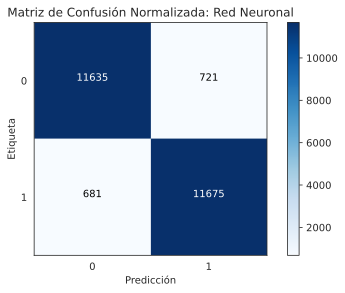

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,),
                      activation = 'relu',# the rectified linear unit function, returns f(x) = max(0, x)
                      solver = 'sgd',
                      alpha = 0,
                      momentum=1) 
model.fit( X_train, y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #
accuracy = accuracy_score(y_test, y_predict) 
print(f'Para 1 capa escondida con {100} neuronas: Precisión {round(accuracy,5)}') # Muestra el resultado

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [ ]:
# Implementación de relu y su derivada: Esta implementación es altamente eficiente usando fancy indexing.
def relu(x):
    return x*(x>0)

def drelu(x):
    return 1.*(x>0)
# Salida tiene activación sigmoide por ser clasificación. Esta implementación es numéricamente estable aprovechando el signo del argumento:
def sigmoid(x):
    return np.where(x>=0,1/(1+np.exp(-x)),np.exp(x)/(1+np.exp(x)))
# Log-Loss binaria (metrica de desempeño). Se utiliza clipping para no evaluar probabilidades 0-1 que puedan generar problemas numéricos.
def log_loss_fun(y,p):  
    p=np.clip(p, 1e-15, 1-1e-15)
    return -(y*np.log(p)+(1-y)*np.log(1-p))
    
# Separación de datos en dos mitades
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.5,
                                                    random_state = 10086)
X_train=X_train.reset_index(drop=True)
y_train=y_train
# Este vector de indices se usará para hacer la selección aleatoria de los minibatches en cada época.
indexes = np.array(range(len(y_train)))
# 1. Inicialización de los pesos: 
# Capa 1: 100 neuronas en la capa por 31 variables de entrada:
W1 = np.random.random((100,31))
b1 = np.random.random((100,1)) # bias capa 1
# Salida: 1 neurona de salida por 100 neuronas en la entrada:
W0 = np.random.random((1,100))
b0 = np.random.random(1) # bias salida
# Se usan 1000 epocas
max_iter = 1000
log_loss = np.zeros(max_iter) # Vector que almacena el log loss alcanzado en cada época
eta = 0.001 # Tasa de aprendizaje
# Se debe definir un tamaño de batch. Escogemos la misma regla que Scikit-Learn por la comparación: Tamaño de batch = min(200, tamaño muestra).
# Como la muestra es > 200. Entonces el batch es de 200 datos. El último batch queda corto si no es divisible por 200.
total_batches = np.int(np.ceil(len(y_train)/200))
for i in range(max_iter): # EPOCAS
  # Creación de mini-batches:
  index_shuff = np.random.permutation(indexes) # Ordena aleatoriamente los indices de los datos
  acc_loss = 0 # Contador del log loss para la época
  for j in range(total_batches): # Recorre los mini-batches
    bstart = j*200
    if j < total_batches-1: # Si no es el ultimo batch use 200 datos y toma los indices del batch actual
      bstop = (j+1)*200
      index_b = index_shuff[bstart:bstop] 
    else: # Si es el utimo batch use los datos que queden y toma los indices del batch actual
      index_b = index_shuff[bstart:]
      bstop = len(index_shuff)-1
    # Toma los datos de entrenamiento correspondientes a la porción de indices seleccionados aleatoriamente 
    X_train_b = X_train.iloc[index_b,]
    y_train_b = y_train[index_b]
    # Transpone para mantener las convenciones (predictores, batch_size)
    X_train_b = np.transpose(np.array(X_train_b))
    y_train_b = np.transpose(np.array(y_train_b))
    # Feed Forward:
    # Capa 1:
    a1 = W1@X_train_b+b1 # Calculo de los a
    z1 =  relu(a1) # Aplica la función de activación
    # Salida:
    a0 = W0@z1+b0 # Calculo de los a
    z0 = sigmoid(a0) # Función de activación sigmoide a la salida
    # Backpropagation:
    acc_loss += np.sum(log_loss_fun(y_train_b,z0)) # Almacena el log loss del batch para todos los datos.
    del0 = (z0-y_train_b) # La derivada de la función de log loss con activación sigmoide a la salida es esto.
    gradw0 = del0@np.transpose(z1) # Calcula el gradiente de la matriz de pesos de salida
    gradb0 = np.mean(del0,1).reshape(-1,1) # Usa el promedio de los datos para el bias de la neurona 
    # Capa 1:
    dz1 = drelu(z1) # Evalua la derivada del relu en ese punto
    del1 = dz1*(np.transpose(W0)@del0) # Calcula el delta usando los pesos anteriores, el delte anterior y la derivada (regla de la cadena).
    gradw1 = del1@np.transpose(X_train_b) # Calcula el gradiente de la matriz de los pesos de la capa escondida.
    gradb1 = np.mean(del1,1).reshape(-1,1) # Usa el promedio de los datos para el bias de cada neurona
    #Actualización de pesos:
    W1 = W1 - eta*gradw1 
    b1 = b1 - eta*gradb1
    W0 = W0 - eta*gradw0
    b0 = b0 - eta*gradb0
  log_loss[i]=acc_loss/X_train.shape[0] # Divide en el número de datos de la iteración (siempre se revisan todos) para calcular el log loss promedio de la iteración (más estable que la suma).



## Gráfica de Evolución del log loss a medida que avanzan las iteraciones

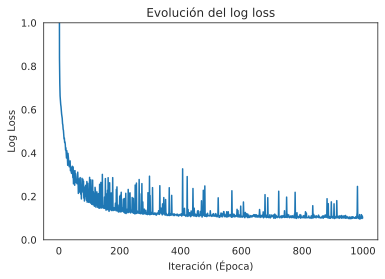

In [ ]:
# Gráfica de evaluación del log loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(max_iter), log_loss)
plt.xlabel("Iteración (Época)")
plt.ylabel("Log Loss")
plt.title("Evolución del log loss")
plt.ylim(0,1)
plt.show()

## Predicción utilizando el modelo entrenado:

Precisión 0.95856
       0      1
0  11591    765
1    259  12097
[[11591   765]
 [  259 12097]]


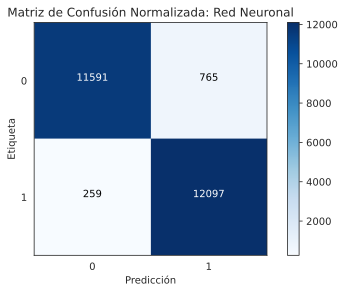

In [ ]:
# Feed Forward:
# Capa 1:
y_test = np.array(y_test)
a1 = W1@np.transpose(np.array(X_test))+b1 # Calculo de los a
z1 =  relu(a1) # Aplica la función de activación
# Salida:
a0 = W0@z1+b0 # Calculo de los a
z0 = sigmoid(a0) # Función de activación sigmoide a la salida
y_predict = np.where(z0<0.5,0,1).flatten()
accuracy = np.sum(np.where(y_test.flatten()==y_predict,1,0))/len(y_test)
print(f'Precisión {round(accuracy,5)}') # Muestra el resultado
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

## Conclusiones Bono
Se implemento la red neuronal con una capa escondida. Se encuentra que la capacidad de predicción es de hecho mejor que la de sci-kit learn con un 95.86% de accuracy versus la de 94.33% usando el paquete. Investigando el paquete se encuentra que esto es probablemente debido a consideraciones de early stopping y de convergencia por época. (La librería para el procedimiento si no hay avance considerable en 10 epocas y tambien cambia de epoca si ve que los minibatches no estan ofreciendo un cambio considerable en los pesos). Tambien porque usamos 1000 epocas en el bono y la librería usa 200. 
Por otra parte, analizando la gráfica de evolución del log loss se observa que el método es estocástico pero que es mucho menos inestable que cuando se utiliza el método en linea (un solo dato). Una gran ventaja del método en batches es esto, que genera mayor estabilidad porque se esta evaluando el modelo en un conjunto mayor de datos por lo que cada iteración puede proveer más información al clasificador. 

Algunas de las limitaciones principales de la implementación del bono son las siguientes. Primero, no se implemento un ciclo para el número de capas. Es decir, la red implementada solo es para una arquitectura de 1 capa y 100 neuronas en la capa escondida. Esto es facil de solucionar si uno utiliza arreglos de 3 posiciones, donde la ultima posición es el número de la capa escondida. Esto mejoraría el uso de memoria del codigo si se considera que no sería necesario declarar una variable para cada elemento de cada capa. Segundo, sería bueno implementar funciones de feed forward y de backpropagation para organizar mejor el codigo. Y que estas funciones simplemente retornen las activaciones (z's) y los gradientes de los pesos. Sin embargo, se considera que la implementación es adecuada en terminos de tiempos de computo por la implementación completamente matricial y el uso de funciones eficientes para evaluar (relu, drelu y sigmoid).
